# TF - IDF TRAINNING

In [16]:
import cupy as cp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, f1_score
from cuml.feature_extraction.text import TfidfVectorizer
from cuml.metrics import accuracy_score
from cuml.preprocessing import LabelEncoder

# Importar modelos de CUML (GPU)
from cuml.svm import LinearSVC
from cuml.ensemble import RandomForestClassifier
from cuml.naive_bayes import MultinomialNB

In [17]:
df = df_csv[['review_comment_message', 'review_score']]

# Convertir a cudf
df_gpu = cudf.from_pandas(df)

In [18]:
X = df_gpu["review_comment_message"]
y_str = df_gpu["review_score"]

# valores nulos
X = X.fillna('')

# Codificar etiquetas
le = LabelEncoder()
y = le.fit_transform(y_str)
print("Etiquetas codificadas.")

Etiquetas codificadas.


In [4]:
# K-Fold
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

In [5]:
def train_and_evaluate(model_name, model_initializer, X, y, kf, label_encoder):

    scores_acc = []
    scores_f1_macro = []
    scores_f1_micro = []
    scores_f1_weighted = []

    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        # Dividir datos
        train_texts, test_texts = X.iloc[train_index], X.iloc[test_index]
        train_labels, test_labels = y.iloc[train_index], y.iloc[test_index]

        # TF-IDF inicialización
        vectorizer = TfidfVectorizer(max_features=100)
        X_train_tfidf = vectorizer.fit_transform(train_texts).toarray()
        X_test_tfidf = vectorizer.transform(test_texts).toarray()

        # Inicializar y entrenar modelo
        model = model_initializer()

        # MultinomialNB requiere no negativos
        if model_name == "Naive Bayes":
             X_train_tfidf = X_train_tfidf.astype('float32')
             X_test_tfidf = X_test_tfidf.astype('float32')

        model.fit(X_train_tfidf, train_labels)

        # Predicciones
        predictions = model.predict(X_test_tfidf)

        # Métricas en GPU (Accuracy)
        acc = accuracy_score(test_labels, predictions)
        scores_acc.append(acc)

        # Mover a CPU para F1 Score de sklearn
        test_labels_cpu = test_labels.to_numpy()
        predictions_cpu = predictions.get()

        f1_macro = f1_score(test_labels_cpu, predictions_cpu, average='macro', zero_division=0)
        f1_micro = f1_score(test_labels_cpu, predictions_cpu, average='micro', zero_division=0)
        f1_weighted = f1_score(test_labels_cpu, predictions_cpu, average='weighted', zero_division=0)

        scores_f1_macro.append(f1_macro)
        scores_f1_micro.append(f1_micro)
        scores_f1_weighted.append(f1_weighted)

        print(f"Fold {fold+1}/{k} - Acc: {acc:.4f} | F1 Macro: {f1_macro:.4f}")

        # Limpieza
        del vectorizer, model, X_train_tfidf, X_test_tfidf, predictions
        cp.cuda.Stream.null.synchronize()

    # Consolidar resultados
    results_data = {
        'Accuracy': scores_acc,
        'F1_Weighted': scores_f1_weighted,
        'F1_Micro': scores_f1_micro,
        'F1_Macro': scores_f1_macro
    }
    df_results = pd.DataFrame(results_data)
    df_results.index = [f"Fold {i+1}" for i in range(k)]

    avg_metrics = df_results.mean()
    print(f"\n--- Promedios para {model_name} ---")
    print(avg_metrics)

    return df_results, avg_metrics

In [6]:
# --- A. SVM Linear ---
results_svm, avg_svm = train_and_evaluate(
    "SVM Linear",
    lambda: LinearSVC(C=1.0),
    X, y, kf, le
)

# --- B. Random Forest ---
results_rf, avg_rf = train_and_evaluate(
    "Random Forest",
    lambda: RandomForestClassifier(n_estimators=100, random_state=42),
    X, y, kf, le
)

# --- C. Naive Bayes ---
results_nb, avg_nb = train_and_evaluate(
    "Naive Bayes",
    lambda: MultinomialNB(),
    X, y, kf, le
)

Fold 1/5 - Acc: 0.6350 | F1 Macro: 0.2789
Fold 2/5 - Acc: 0.6400 | F1 Macro: 0.2802
Fold 3/5 - Acc: 0.6376 | F1 Macro: 0.2799
Fold 4/5 - Acc: 0.6398 | F1 Macro: 0.2802
Fold 5/5 - Acc: 0.6336 | F1 Macro: 0.2750

--- Promedios para SVM Linear ---
Accuracy       0.637196
F1_Weighted    0.518891
F1_Micro       0.637196
F1_Macro       0.278857
dtype: float64
Fold 1/5 - Acc: 0.6396 | F1 Macro: 0.3041
Fold 2/5 - Acc: 0.6441 | F1 Macro: 0.3050
Fold 3/5 - Acc: 0.6412 | F1 Macro: 0.3034
Fold 4/5 - Acc: 0.6450 | F1 Macro: 0.3139
Fold 5/5 - Acc: 0.6415 | F1 Macro: 0.3068

--- Promedios para Random Forest ---
Accuracy       0.642269
F1_Weighted    0.530067
F1_Micro       0.642269
F1_Macro       0.306657
dtype: float64
Fold 1/5 - Acc: 0.6328 | F1 Macro: 0.2793
Fold 2/5 - Acc: 0.6389 | F1 Macro: 0.2833
Fold 3/5 - Acc: 0.6342 | F1 Macro: 0.2786
Fold 4/5 - Acc: 0.6395 | F1 Macro: 0.2832
Fold 5/5 - Acc: 0.6342 | F1 Macro: 0.2802

--- Promedios para Naive Bayes ---
Accuracy       0.635950
F1_Weighted    

In [8]:
def plot_model_performance(df_results, model_name, color_palette):
    plt.figure(figsize=(10, 6))
    avg_metrics = df_results.mean()
    metrics_to_plot = ['Accuracy', 'F1_Weighted', 'F1_Macro']
    avg_values = avg_metrics[metrics_to_plot]

    bars = plt.bar(metrics_to_plot, avg_values, color=color_palette)
    plt.title(f'Rendimiento Promedio: {model_name}', fontsize=16)
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{height:.4f}', ha='center', va='bottom', fontsize=12)
    plt.show()


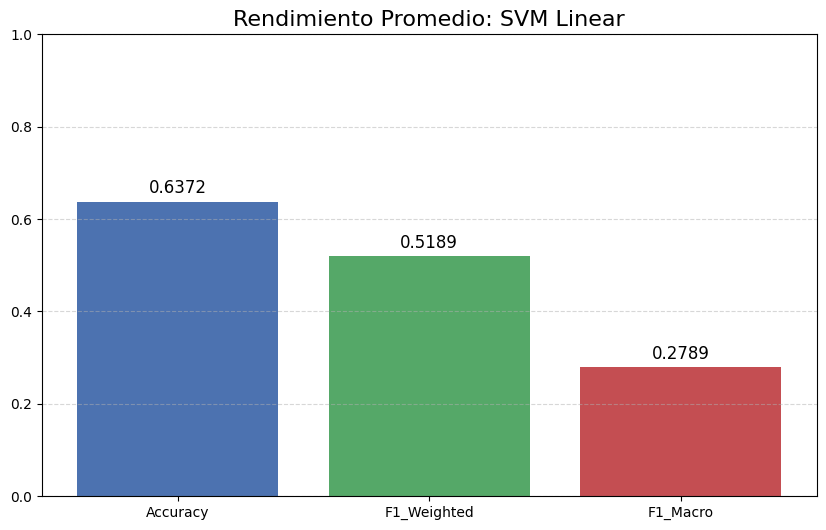

In [9]:
# Graficar SVM
plot_model_performance(results_svm, "SVM Linear", ['#4c72b0', '#55a868', '#c44e52'])

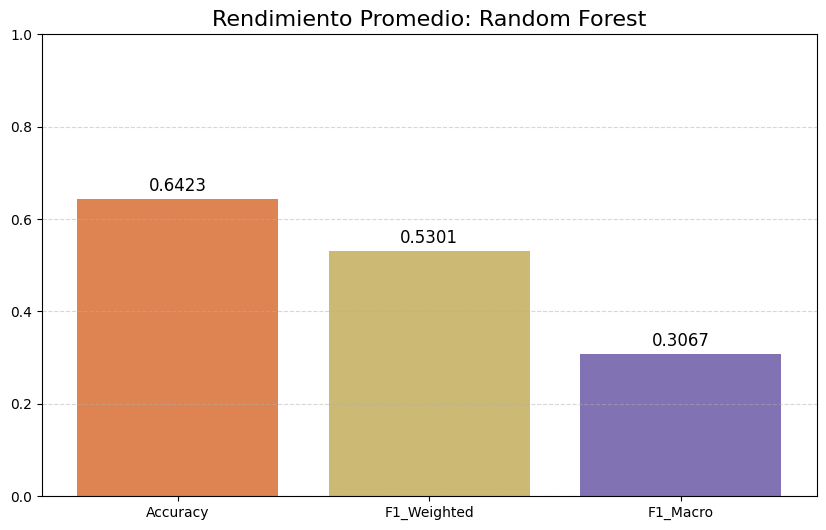

In [10]:
# Graficar Random Forest
plot_model_performance(results_rf, "Random Forest", ['#dd8452', '#ccb974', '#8172b3'])

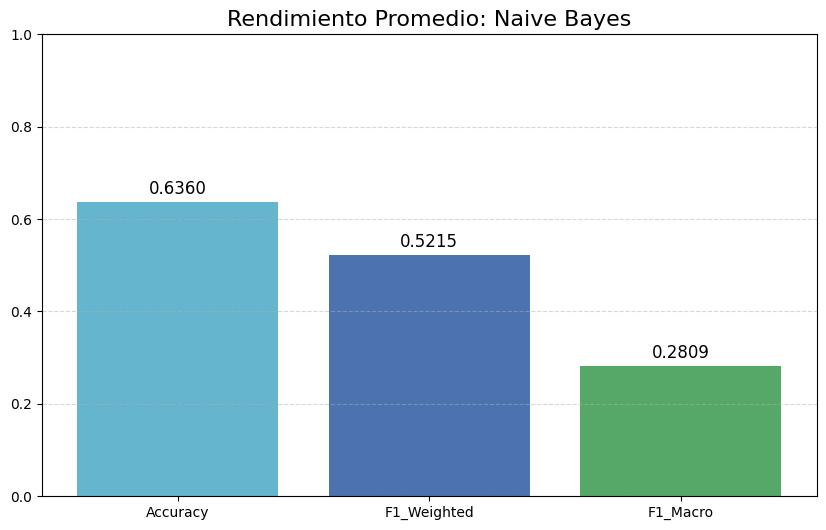

In [11]:
# Graficar Naive Bayes
plot_model_performance(results_nb, "Naive Bayes", ['#64b5cd', '#4c72b0', '#55a868'])

In [12]:
comparison_data = {
    'Modelo': ['SVM Linear', 'Random Forest', 'Naive Bayes'],
    'Accuracy': [avg_svm['Accuracy'], avg_rf['Accuracy'], avg_nb['Accuracy']],
    'F1 Weighted': [avg_svm['F1_Weighted'], avg_rf['F1_Weighted'], avg_nb['F1_Weighted']],
    'F1 Macro': [avg_svm['F1_Macro'], avg_rf['F1_Macro'], avg_nb['F1_Macro']]
}

df_comparison = pd.DataFrame(comparison_data)

### Comparación final

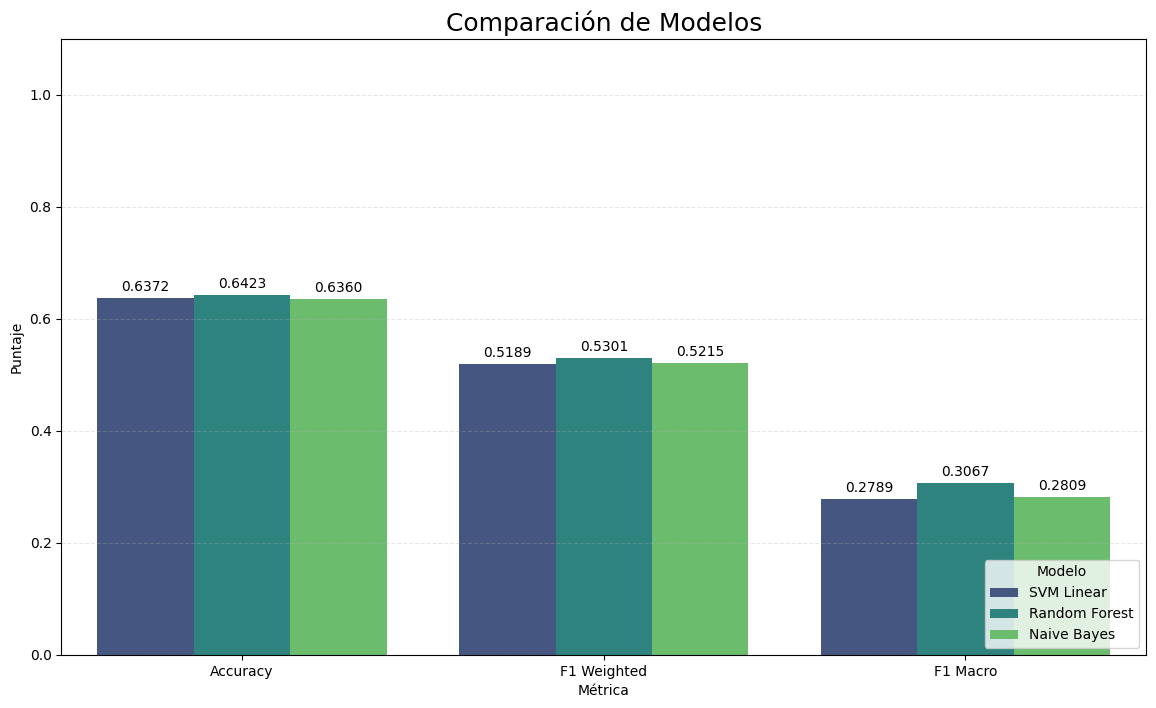

In [15]:
df_melted = df_comparison.melt(id_vars="Modelo", var_name="Métrica", value_name="Puntaje")

plt.figure(figsize=(14, 8))
ax = sns.barplot(data=df_melted, x="Métrica", y="Puntaje", hue="Modelo", palette="viridis")

plt.title("Comparación de Modelos", fontsize=18)
plt.ylim(0, 1.1) # Un poco más de espacio para las etiquetas
plt.legend(loc='lower right', title='Modelo')
plt.grid(axis='y', linestyle='--', alpha=0.3)
for container in ax.containers:
    ax.bar_label(container, fmt='%.4f', padding=3)
plt.show()

In [14]:
print(df_comparison.set_index('Modelo'))

               Accuracy  F1 Weighted  F1 Macro
Modelo                                        
SVM Linear     0.637196     0.518891  0.278857
Random Forest  0.642269     0.530067  0.306657
Naive Bayes    0.635950     0.521455  0.280921


In [23]:
df_clean = df_csv[['review_comment_message', 'review_score']].copy()
df_clean = df_clean.dropna(subset=['review_comment_message'])
df_clean['review_comment_message'] = df_clean['review_comment_message'].astype(str)
df_clean = df_clean[df_clean['review_comment_message'].str.strip() != '']
df_clean = df_clean[df_clean['review_comment_message'].str.lower() != 'nan']
print(f"Dimensiones después de limpiar: {df_clean.shape}")

# Ahora pasamos los datos limpios a la GPU
df_gpu = cudf.from_pandas(df_clean)

X = df_gpu["review_comment_message"]
y_str = df_gpu["review_score"]

le = LabelEncoder()
y = le.fit_transform(y_str)

Dimensiones después de limpiar: (47614, 2)


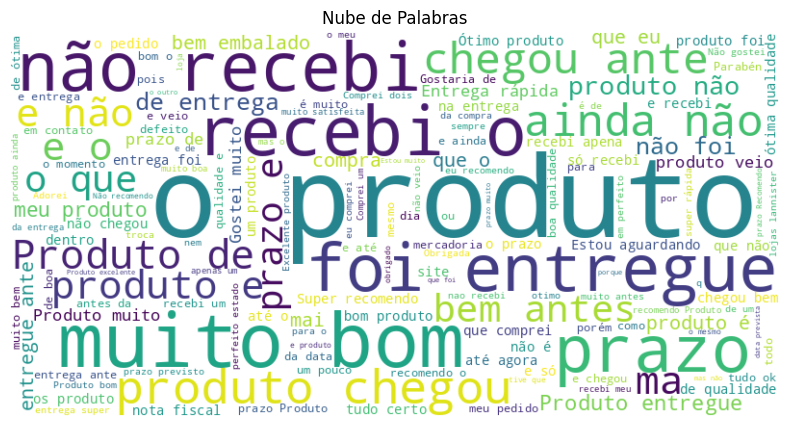

In [24]:
# GENERAR NUBE DE PALABRAS
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text_series = df_gpu['review_comment_message'].to_pandas()
all_text = " ".join(text for text in text_series)
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=150,
    colormap='viridis'
).generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras')
plt.show()

## RECOMENDACIONES


*   Probar otros clasificadores
*   Emplear tecnicas de representacion de texto basadas en word embedding

